# Intro

Time series processing is a well-known and extensively researched problem. Moreover - many people naturally understand, what a time series is, and how it is structured. Things start to get complicated once you are about to prepare time-dependent data for modeling with neural networks. Three-dimensional structures are not that easy to imagine initially. After reading this blog post, you will:

1. Understand the data should be pre-processed for LSTM neural networks;
2. Understand the benefits of keeping time-dependent structures in data;
3. See a practical example of wrongly and correctly prepared data for LSTM. 

Technologies used in this post are:
1. Pandas
2. Numpy
3. Tensorflow/Keras.

This is a companion notebook for a blogpost. It gathers most of the code presented on a blog.

# Library imports

In [8]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import pingouin as pg
import seaborn as sns
import scipy.stats as st

import tensorflow as tf
import tensorflow.keras as krs
import xgboost as xgb
import gc

from typing import List, Tuple

from scikeras.wrappers import KerasClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [4]:
%matplotlib inline

# The problem

Let’s imagine the following situation: we have three different processes, logging some information over time. These might be some sensors, loggers, or robots; details do not matter. Each of these traces has a different characteristic and morphology of a signal.

# Data prep

I want to keep this tutorial simple, without unnecessary details and additional functions. Therefore, let’s create some artificial data with different characteristics and assign labels 0, 1, and 2.

To make things a bit harder for the algorithm, I have added some slight random noise to functions (line 2,3,4) so that it won’t be 100% aligned with the perfect sinusoid equation.

In [5]:
x = np.linspace(start=0, stop=500, num=1000)
y1 = np.sin(x) + np.random.normal(size=x.shape[0], loc=0, scale=0.5)
y2 = np.sin(0.05*x) + np.sin(0.3* np.pi * x) + np.random.normal(size=x.shape[0], loc=0, scale=0.5)
y3 = np.sin(2 * x) +  np.sin(0.5 * 2 * x) + np.random.normal(size=x.shape[0], loc=0, scale=0.5)

In [50]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y1, name="y1",
                    line_shape='linear'))
fig.add_trace(go.Scatter(x=x, y=y2, name="y2",
                    line_shape='linear'))
fig.add_trace(go.Scatter(x=x, y=y3, name="y3",
                    line_shape='linear'))


fig.update_traces(hoverinfo='text+name', mode='lines+markers')
fig.update_layout(legend=dict(y=0.5, traceorder='reversed', font_size=16))
fig.write_json("sinusoids.json")
fig.show()

## Lagged data

Once we have done that, we can utilize our function for building lagged time series to prepare time slices for each process. We will use K = 10 lags here (9 lags + so-called lag-0: the “current” time).

In [9]:
def generate_lagged_data(y: pd.Series, k_lags: int) -> pd.DataFrame:
    """
    Generates a lagged time series data in a fromat y, y-1, y-2, ..., y-K up to
    K-th lag. So the total number of time records is k + 1: lags + "0" time (current time).

    Parameters
    ----------
    y : pd.Series
        Original time series.
    k_lags: int
        Number of lags to generate.

    Returns
    ----------
    pd.DataFrame
        A lagged dataframe in format y, y-1, y-2, ..., y-K.
    """
    data = pd.DataFrame({'y': y})
    for t in range(k_lags + 1):
        fname = f"y-{t}" if t > 0 else "y"
        lagged = y.shift(t)
        data[fname] = lagged
    return data

For a trivial case, the output from this function looks like this:

### Trivial example

In [10]:
example_ts = pd.Series(np.arange(10))
lagged_example = generate_lagged_data(example_ts, 4).dropna()
lagged_example

,y,y-1,y-2,y-3,y-4
4,4,3.0,2.0,1.0,0.0
5,5,4.0,3.0,2.0,1.0
6,6,5.0,4.0,3.0,2.0
7,7,6.0,5.0,4.0,3.0
8,8,7.0,6.0,5.0,4.0
9,9,8.0,7.0,6.0,5.0


In [11]:
lagged_example_for_lstm = lagged_example.values.reshape((lagged_example.shape[0], 5, 1))
lagged_example_for_lstm.shape

(6, 5, 1)

### Lagging the data

Let's lag the actual training data now.

In [12]:
NLAGS = 9

In [13]:
lagged_y1 = generate_lagged_data(pd.Series(y1), NLAGS).dropna()
lagged_y1['cls'] = 0
lagged_y2 = generate_lagged_data(pd.Series(y2), NLAGS).dropna()
lagged_y2['cls'] = 1
lagged_y3 = generate_lagged_data(pd.Series(y3), NLAGS).dropna()
lagged_y3['cls'] = 2

all_data = pd.concat([lagged_y1, lagged_y2, lagged_y3], ignore_index=True)

In [14]:
all_data.head(3)

,y,y-1,y-2,y-3,y-4,y-5,y-6,y-7,y-8,y-9,cls
0,0.564448,-0.070279,-0.402042,0.428768,0.513845,1.142850,0.728924,0.341466,0.658641,-0.252896,0
1,-0.725219,0.564448,-0.070279,-0.402042,0.428768,0.513845,1.142850,0.728924,0.341466,0.658641,0
2,-0.663930,-0.725219,0.564448,-0.070279,-0.402042,0.428768,0.513845,1.142850,0.728924,0.341466,0


In [51]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=all_data.iloc[4], name="y1",
                    line_shape='linear'))
fig.write_json("slice.json")
fig.show()

# The experiment

We will keep the last 20% of the data samples as a test set, and the remaining will be mixed up together and used during training.

We will normalize the training data and use normalizer trained on it to do the same with test data.

In [30]:
def build_train_test_data(series: List[pd.DataFrame], test_perc: float = 0.2) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Builds a train-test dataset using a time-split method. We will keep last test_prec of each time series
    as a test set, training on the remaining data.
    """
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()
    for ts in series:
        test_nobs = int(test_perc * ts.shape[0])
        ts_train = ts.iloc[:-test_nobs]
        ts_test = ts.tail(test_nobs)
        
        train_data = pd.concat([train_data, ts_train], ignore_index=True)
        test_data = pd.concat([test_data, ts_test], ignore_index=True)
    return train_data, test_data

train, test = build_train_test_data([lagged_y1, lagged_y2, lagged_y3])
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train.drop(columns='cls'), test.drop(columns='cls'), train.cls, test.cls
X_train = np.expand_dims(scaler.fit_transform(X_train), -1)
X_test = np.expand_dims(scaler.transform(X_test), -1)

y_train_ohe = krs.utils.to_categorical(y_train, num_classes=3)
y_test_ohe = krs.utils.to_categorical(y_test, num_classes=3)

X_train.shape, X_test.shape

((2379, 10, 1), (594, 10, 1))

## Model prep

Now it’s time to conduct our experiment. As a baseline to compare with, we will use random guessing with prior probability :) We would expect our model to be better than that. The architecture for this LSTM has been arbitrarily chosen - it’s not the main point of this exercise, so repeated cross-validation or using Keras Tuner for finding the best hyperparameters is beyond the scope of this post.

The function below wraps model building into function so it can be later used by Scikit-learn API.

In [31]:
krs.backend.clear_session()
gc.collect()

def build_model() -> krs.Model:
    """
    Builds a Keras model. A wrapper function for SciKeras.
    """
    inp = krs.layers.Input(shape=(NLAGS+1, 1))
    lstm_out = krs.layers.LSTM(32)(inp)
    dense1 = krs.layers.Dense(16, activation='relu')(lstm_out)
    dense2 = krs.layers.Dense(16, activation='relu')(dense1)
    out = krs.layers.Dense(3, activation='softmax')(dense2)
    model = krs.models.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', krs.metrics.Precision(), krs.metrics.Recall()])
    return model

model = build_model()

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                                                                 
Total params: 5,203
Trainable params: 5,203
Non-trainable params: 0
_________________________________________________________________


In [33]:
krs.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## LSTM vs random

Let's run the experiment.

In [ ]:
model_wrapper = KerasClassifier(build_model, epochs=10, batch_size=32, verbose=0)
dummy = DummyClassifier(strategy='stratified', random_state=123)
f1 = make_scorer(lambda y_true, y_pred: f1_score(y_true, y_pred, average='micro'))
kf = KFold(n_splits=10)
model_cv = cross_val_score(model_wrapper, X_train, y_train_ohe, cv=kf, scoring=f1, n_jobs=10)
dummy_cv = cross_val_score(dummy, X_train, y_train_ohe, cv=kf, scoring=f1, n_jobs=10)

cv_scores = pd.DataFrame({'LSTM': model_cv, 'Dummy': dummy_cv})

In the experiment, the following things happened:

**Line 1**: Use Scikeras API to make Keras model usable within cross-validation

**Line 2**: Prepare a dummy classifier that randomly predicts classes based on their prior probability.

**Line 3**: Prepare a model metric for comparison: micro-averaged F1 score.

**Line 4-6**: Perform repeated stratified K-fold cross-validation on each model using the metric provided.

**Line 8**: Gather all scores in a one data frame for later comparison

## Compare results

The model is trained, so let’s evaluate it on the test set. And use a non-parametric statistical test to compare the statistical significance of the results against a random baseline.

To compare results, we will utilize the non-parametric Wilcoxon signed-rank test. Non-parametric tests are recommended every time; we cannot guarantee that strict assumptions, e.g., normality of errors, heteroskedasticity, independence of samples, etc., are not violated [Salzberg, S. L. (1997) “On comparing classifiers: Pitfalls to avoid and a recommended approach”, Data mining and knowledge discovery. Springer, nr 1(3), ss. 317–328.; Demšar, J. (2006) “Statistical comparisons of classifiers over multiple data sets”, Journal of Machine learning research, nr 7(Jan), ss. 1–30.]. Our null hypothesis is that there is no difference between the two classifiers. An alternative hypothesis is that the difference is present in favor of an LSTM. We will conduct a test on a significance level alpha = 0.05 (meaning that we accept only a 5% chance that observed results are accidental).

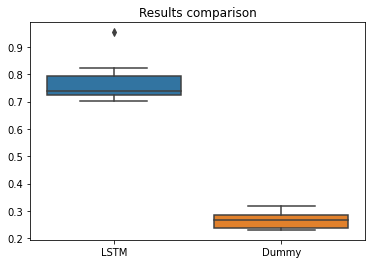

In [35]:
fig = sns.boxplot(data=cv_scores);
fig.set_title("Results comparison");

In [36]:
cv_scores.describe()

,LSTM,Dummy
count,10.000000,10.000000
mean,0.770094,0.265418
std,0.074791,0.030296
min,0.701681,0.230769
25%,0.724790,0.236102
50%,0.739496,0.266807
75%,0.792017,0.284501
max,0.953782,0.317797


In [37]:
st.wilcoxon(model_cv, dummy_cv, alternative='greater')

WilcoxonResult(statistic=55.0, pvalue=0.0009765625)

As we can see by a naked eye: the LSTM model outperformed random choice significantly. Our statistical test allows us to reject the null hypothesis :)

## Test data check

We can evaluate our LSTM model on a test data to check how well it performs.

In [47]:
model = build_model()
history = model.fit(X_train, y_train_ohe, epochs=10, batch_size=32)
yhat_lstm = model.predict(X_test).argmax(axis=1)
print(classification_report(y_test, yhat_lstm))

Epoch 1/10
75/75 [==============================] - 2s 8ms/step - loss: 1.0413 - accuracy: 0.4191 - precision_2: 0.9349 - recall_2: 0.0664
Epoch 2/10
75/75 [==============================] - 1s 10ms/step - loss: 0.8887 - accuracy: 0.5645 - precision_2: 0.8456 - recall_2: 0.2417
Epoch 3/10
75/75 [==============================] - 1s 7ms/step - loss: 0.8035 - accuracy: 0.6343 - precision_2: 0.7673 - recall_2: 0.3493
Epoch 4/10
75/75 [==============================] - 1s 9ms/step - loss: 0.7440 - accuracy: 0.6877 - precision_2: 0.7871 - recall_2: 0.5019
Epoch 5/10
75/75 [==============================] - 1s 7ms/step - loss: 0.6626 - accuracy: 0.7301 - precision_2: 0.7807 - recall_2: 0.6419
Epoch 6/10
75/75 [==============================] - 0s 6ms/step - loss: 0.5989 - accuracy: 0.7499 - precision_2: 0.7830 - recall_2: 0.6978
Epoch 7/10
75/75 [==============================] - 0s 6ms/step - loss: 0.5419 - accuracy: 0.7848 - precision_2: 0.8247 - recall_2: 0.7276
Epoch 8/10
75/75 [========

# Random sampling data

You might wonder - “ok, but what will happen if I ignore the time dependence and just sample points at random from each process. This is an easy task - each curve is a sinusoid with a characteristic morphology - if we sample enough data points, it should be sufficient to recognize a typical range of values for each type”. Here we treat each data point as an iid datum - independent from others but from the same characteristic distribution, specific for each class. So we will turn the whole exercise into a typical classification problem from tabular data.

We might ignore for a while the fact that this is the fundamentally wrong approach because the problem IS a time series classification and check if it’s going to work after all. Let’s try: we skip the lagging part entirely and randomly sample data points for each class. To make it easier for the algorithm: we will sample with a replacement for each time series so that the algorithm may see the same data points twice: in training and testing. It should be easy, shouldn’t it? We will use one of the Gradient Boosting family models to model such data.

In [39]:
np.random.seed(123)

In [40]:
def generate_iid_data(ts: np.array, label: int, n_features: int, nsamp: int) -> pd.DataFrame:
    """
    Generates random samples with replacement, assuming that the data is IID. It does not preserve
    a time dependence and samples each data point multiple times.
    """
    rnd_features = {}
    for idx in range(n_features):
        rnd_feature = np.random.choice(ts, size=nsamp, replace=True)
        rnd_features[f"f_{idx}"] = rnd_feature
    rnd_df = pd.DataFrame(rnd_features)
    rnd_df['y'] = label
    return rnd_df

rnd_data = pd.DataFrame()
for idx, ts in enumerate([y1, y2, y3]):
    df = generate_iid_data(ts, idx, NLAGS+1, 800)
    rnd_data = pd.concat([rnd_data, df], ignore_index=True)
rnd_data.shape

(2400, 11)

In [41]:
X_rnd, y_rnd = rnd_data.drop(columns='y'), rnd_data.y
X_train_rnd, X_test_rnd, y_train_rnd, y_test_rnd = train_test_split(X_rnd, y_rnd, train_size=0.8, random_state=123)

In [42]:
xgb_clf = xgb.XGBClassifier(max_depth=10, learning_rate=0.01, n_estimators=500)
xgb_rnd_cv = cross_val_score(xgb_clf, X_train_rnd, y_train_rnd, cv=kf, scoring=f1)

In [43]:
xgb_clf = xgb.XGBClassifier(max_depth=10, learning_rate=0.01, n_estimators=500)
xgb_clf.fit(X_train_rnd, y_train_rnd)
yhat_xgb = xgb_clf.predict(X_test_rnd)
print(classification_report(y_test_rnd, yhat_xgb))

              precision    recall  f1-score   support

           0       0.61      0.81      0.70       149
           1       0.54      0.51      0.52       158
           2       0.54      0.42      0.47       173

    accuracy                           0.57       480
   macro avg       0.57      0.58      0.57       480
weighted avg       0.56      0.57      0.56       480



<AxesSubplot:>

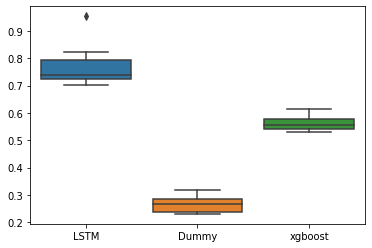

In [44]:
cv_scores['xgboost'] = xgb_rnd_cv
sns.boxplot(data=cv_scores)

In [45]:
pg.friedman(data=cv_scores)

,Source,W,ddof1,Q,p-unc
Friedman,Within,1.0,2,20.0,0.000045


In [46]:
pg.pairwise_ttests(cv_scores.melt(), between='variable', dv='value', parametric=False).round(5)

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,hedges
0,variable,Dummy,LSTM,False,False,0.0,two-sided,0.00018,-8.47105
1,variable,Dummy,xgboost,False,False,0.0,two-sided,0.00017,-10.01235
2,variable,LSTM,xgboost,False,False,100.0,two-sided,0.00018,3.56603


And again, there are no surprises here. We can safely reject the null hypothesis and (after pairwise testing) see clearly, that LSTM, preserving time-dependence, performs much better than XGBoots, even after aggressive resampling with replacement.

# Summary


The points below briefly summarize what has been discussed in this blogpost:

1. LSTM requires data in a format: N samples x T time steps x F features.
2. For univariate time series, F = 1, so the data shape becomes N x T x 1
Such a structure can be generated from data by subsequent shifting the time series.
3. A predictive model that preserves the time-dependence performs much better than random sampling, which treats the data as iid. This is a fundamentally wrong approach for such problems. 